In [1]:
import numpy as np 
import musclebeachtools as mbt
import os
import glob
import pandas as pd
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
import matplotlib.patches as patches
import seaborn as sns
from copy import deepcopy as cdc
import scipy.io as sio
import scipy
import datetime as dt
import plotly
import plotly.graph_objects as go
from matplotlib.animation import FuncAnimation
import math
import sahara_work as saw
from statsmodels.distributions.empirical_distribution import ECDF
import statsmodels.formula.api as smf
import neuraltoolkit as ntk
from scipy.stats import ks_2samp
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score,v_measure_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import random

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams.update({'font.family':'Arial'})


from sys import platform
if platform == 'darwin':
    basedir = 'Volumes'
else:
    basedir = 'media'

from datetime import datetime

savedir = f'/{basedir}/HlabShare/te4_manuscript_james/manuscript_folders/te4_figure_1/'
today = datetime.today().strftime('%Y-%m-%d')

cmap = "YlGnBu"

SAVEFIGS = 1


/hlabhome/wg-mjames/.conda/envs/james_test/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/hlabhome/wg-mjames/.conda/envs/james_test/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
# load dataframe containing DCC gentype, age, etc. This is a big one. 
dfall = pd.read_pickle(f'/{basedir}/HlabShare/te4_manuscript_james/indv_param_with_dist8_justca1_v13.pkl')
dfall = dfall.drop_duplicates(subset=['animal','probe', 'date', 'time_frame', 'block_num', 'scored'], keep = 'last')

dfall_FR = pd.read_pickle(f'/{basedir}/HlabShare/te4_manuscript_james/manuscript_folders/te4_figure_1/dfall_FR.pkl')
dfall_FR['age_days'] = dfall_FR.time/(24*3600)  
dfall_FR = dfall_FR[dfall_FR.fr < 50]



In [3]:
def set_phase(age):
    phase = 'C'
    if age < 75:
        phase = 'A'
    elif age < 300:
        phase = 'B'
    return phase

def get_real_age(start_time, birth, block_num, hour_bins=4):
    start_time = dt.datetime.strptime(start_time, '%Y-%m-%d %H:%M:%S')
    birth = dt.datetime.strptime(birth, '%Y-%m-%d %H:%M:%S')
    age = start_time - birth
    age = age + dt.timedelta(hours = int((block_num * hour_bins)))
    age_in_days = age.days + (age.seconds / (60*60*24))
    return age_in_days

def clean_df(df):
    df['age'] = pd.to_timedelta(df['age'])
    df['age_days'] = df.apply(lambda x: x['age'].total_seconds()/60/60/24, axis=1)
    df['phase'] = df.apply(lambda x: set_phase(x['age_days']), axis=1)
    return df

def get_days_old(bday, current_day, time_frame, block_num, animal):
    if animal == 'eab47' or animal == 'eab' or animal == 'eab50':
        year = 2019
    elif animal == 'eab40':
        year = 2018
    else:
        year = 2020
    d1 = dt.date(year, int(current_day[0:2]), int(current_day[2:]))
    delta = d1-bday
    days = delta.days
    start_hour = int(time_frame[:time_frame.find('_')])
    num_diff = 4*int(block_num)
    time_of_day = start_hour+num_diff
    dec = time_of_day/24
    p = round(days+dec,2)
    return p

def get_error_points(start_age, ages):
    d_thresh = .17
    diff = np.diff(ages)
    dat = []
    if ages[0] - start_age > d_thresh:
        dat.append([start_age, ages[0]-start_age])
    for i, d in enumerate(diff):
        if d>d_thresh:
            dat.append([ages[i], d])
    return dat

def choose(animals, probe, thisan, thispr):
    if probe == -1:
        print(thisan, thispr)
    return (thisan in animals and thispr == probe)

def get_age_cat(geno, age):
    if geno == 'wt':
        cat = 'wt'
    else:
        if age <= 70:
            cat = 'early'
        elif age <= 100:
            cat = 'mid'
        elif age <=300:
            cat = 'late_mid'
        else:
            cat = 'late'
        cat = cat +'-'+geno
    return cat

def get_all_info(df, animal, window=7):
    d = df[df.apply(lambda x: choose(animal, s.get_probe(x['animal'], 'CA1'), x['animal'], x['probe']), axis=1)].sort_values(by=['date','time_frame', 'block_num'], key = lambda col: col.astype(int))
    d['rolling_dcc'] = d['dcc'].rolling(window=window).mean()
    
    #only keeping this if i need to go back to mpl from seaborn
    dcc = d['rolling_dcc'].astype(float).to_numpy()
    p_b = d['p_val_b'].astype(float).to_numpy()
    p_t = d['p_val_t'].astype(float).to_numpy()
    colors = ['slateblue' if (a>0.05 and b>0.05) else 'red' for a, b in zip(p_b, p_t)]
    ages = d['age'].astype(float).to_numpy()
    k2b = d['k2b'].rolling(window=window).mean().astype(float).to_numpy()
    k2t = d['k2t'].rolling(window=window).mean().astype(float).to_numpy()
    
    return d, dcc, colors, ages, [k2b, k2t]

def get_info(df, animal, window = 6):
    df = clean_df(df)
    d = df[df.apply(lambda x: choose(animal, saw.get_probe(x['animal'], 'CA1'), x['animal'], x['probe']), axis=1)].sort_values(by=['date','time_frame', 'block_num'], key = lambda col: col.astype(int))
    d['rolling_dcc'] = df.groupby(['animal'])['dcc'].transform(lambda x: x.rolling(window, 1).mean())
    return d


def get_fr_info(df, animals):
    d = df[df.apply(lambda x: choose(animals, 1, x['animal'], 1), axis=1)].sort_values(by=['days_old', 'cell_idx'], key = lambda col: col.astype(int))
    return d

def LNOCV(df,group_col='animal',X='fr',y='geno',N=1,max_splits=None):
    from itertools import combinations
    left_outs = list(combinations(set(df[group_col]), N))
    np.random.shuffle(left_outs)
    f1s,vms,cms = [],[],[]
    if max_splits is not None:
        left_outs = left_outs[:max_splits]
    left_outs = [list(lo) for lo in left_outs]
    for left_out in left_outs:
        test_df = df[df[group_col].isin(left_out)]
        train_df = df[~df[group_col].isin(left_out)]
        print(set(train_df[group_col]),set(test_df[group_col]))
        logreg = LogisticRegression(class_weight='balanced')
        logreg.fit(train_df[X].to_numpy().reshape(-1, 1),train_df[y].to_numpy().reshape(-1, 1))
        y_pred = logreg.predict(test_df[X].to_numpy().reshape(-1, 1))
        y_test = np.ndarray.flatten(test_df[y].to_numpy().reshape(-1, 1))
        f1 = f1_score(y_test, y_pred, average='micro')
        f1s.append(f1)
        vm = v_measure_score(y_test, y_pred)
        vms.append(vm)
        cm = confusion_matrix(y_test, y_pred)#, normalize='true') #why is this erroring?
        cms.append(cm)
        print(left_out, f1, vm, cm)
    return left_outs, f1s, vms, cms

def LNOCV_classwise(df,animal_col='animal',X='fr',y='geno',max_splits=None):
    from itertools import product
    f1s,vms,cms = [],[],[]
    group_mems_lol = []
    for genotype in set(df[y]): #select all pairs of [wt/e4,te4] and put in list
        group_mems = list(set(df[df[y]==genotype][animal_col]))
        group_mems_lol.append(group_mems)
    left_outs = [list(p) for p in product(*group_mems_lol)]
    np.random.shuffle(left_outs) #shuffle list of pairs
    if max_splits is not None: #if you only want to test on some (max_split) number of pairs
        left_outs = left_outs[:max_splits]
    for left_out in left_outs: #for left-out (test set) pair
        test_df = df[df[animal_col].isin(left_out)] #left-out as test set
        train_df = df[~df[animal_col].isin(left_out)] #every other animal as train set
        logreg = LogisticRegression(class_weight='balanced',solver='lbfgs') #creates a logistic regression model object
        logreg.fit(train_df[X].to_numpy().reshape(-1, 1),train_df[y].to_numpy().reshape(-1, 1)) #train logreg
        y_pred = np.ndarray.flatten(logreg.predict(test_df[X].to_numpy().reshape(-1, 1))) #predit genotype on test set
        y_test = np.ndarray.flatten(test_df[y].to_numpy().reshape(-1, 1)) #actual genotypes of test set
        f1 = f1_score(y_test, y_pred, average='micro')
        f1s.append(f1)
        vm = v_measure_score(y_test, y_pred)
        vms.append(vm)
        cm = confusion_matrix(y_test, y_pred)#, normalize='true') #why is this erroring?
        cms.append(cm)
        print(left_out, f1, vm, cm)
    return left_outs, f1s, vms, cms



In [4]:
blacklist = {
    'caf96' : 'bad distributions',
    #'eab50' : 'betsy',
    #'eab40' : 'betsy',
    #'caf90' : 'bad recording',
    #'caf92' : 'bad recording',
    #'caf95' : 'bad recording',
    #'caf94' : 'bad recording'
}

allanimals = dfall['animal'].unique()
animals = [a for a in allanimals if a not in blacklist.keys()]
df = clean_df(dfall)
df = df[(df.animal.isin(animals)) & (df.geno.isin(['e4', 'wt', 'te4']))]
df = df[df.num_cells >= 10]
df = df.drop_duplicates(subset=['animal','probe', 'date', 'time_frame', 'block_num', 'scored'], keep = 'last')
dfpassed = df[df.passed == True]


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


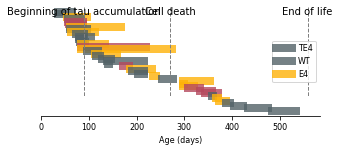

In [5]:
# MAKE TIMELINE PANEL
fig1, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(5,2))


sorteddf = df.sort_values(by='age_days')
animal_list = sorteddf.animal.unique()

max_ages = []
min_ages = []
plotting_array = []



for i in (animal_list):
    
    temp_array = []
    temp_array = [sorteddf[sorteddf.animal == i].geno.unique()[0], i, min(sorteddf[sorteddf.animal == str(i)].age_days), max(sorteddf[sorteddf.animal == str(i)].age_days)]
    plotting_array.append(temp_array)
        
    max_ages.append(max(sorteddf[sorteddf.animal == str(i)].age_days))
    min_ages.append(min(sorteddf[sorteddf.animal == str(i)].age_days))
   

y = 2
ticks = []
ii = 0
jj = 0
kk = 0

for i, row in enumerate(plotting_array):
    
    ticks.append(y)
    x = row[2:]
    ys = [y, y]
    
    if row[0] == 'wt':
        l = 'WT'
        c = sns.xkcd_rgb['gunmetal']
        ii+=1
        
    elif row[0] == 'te4':
        l = 'TE4'
        c = sns.xkcd_rgb['saffron']
        jj+=1
        
    else:
        l = 'E4'
        c = sns.xkcd_rgb['dark rose']
        kk+=1
         
    if i in [2,3,4]:    
        ax1.plot(x, ys, color = c, linewidth=8, alpha = 0.8, label = l)
    else:
        ax1.plot(x, ys, color = c, linewidth=8, alpha = 0.8)
        
    y-=0.1
    
ax1.legend(['TE4','WT','E4'],loc=7, fontsize = 8)

ymax = 2.2
ymin = -1.4

b = ax1.get_xlim()[0]
e = ax1.get_xlim()[1]
xs = [ 90, 270, e]
ys = np.repeat(ymax,5)

level = ymin
labs = ['Beginning of tau accumulation', 'Cell death', 'End of life']

ax1.vlines(xs, 2.2, level, color='grey', linestyle='--', lw = 1)

ax1.set_xlim(0, ax1.get_xlim()[1])
ax1.set_ylim(ax1.get_ylim()[0], ymax)

for i in range(len(xs)):
    ax1.annotate(labs[i], xy=(xs[i], ymax), xytext=(0, -10), textcoords="offset points", horizontalalignment="center",
                verticalalignment="bottom")

ax1.set_yticks([])
plt.xticks(fontsize=8)
plt.xlabel('Age (days)',fontsize=8)

sns.despine(left = True)

if SAVEFIGS == 1:
    fn = f'{today}_timeline_panel.pdf'
    fig1.savefig(savedir+fn)

In [5]:
Ages = [393, 371, 354, 280, 269, 242, 167, 134, 112, 96]
#Volumes = [3.76, 2.98, 6.51, 6.60, 5.77, 8.07, 8.29, 8.00, 7.62, 6.30]
#Volumes = [3.76, 2.98, 6.51, 6.60, 5.77, 6.391, 8.29, 8.00, 7.62, 6.30]
#Volumes = [3.76, 2.98, 6.51, 6.60, 5.77, 7.45, 8.29, 8.00, 7.62, 8.28]
Volumes = [3.76, 2.98, 6.51, 6.60, 5.77, 8.07, 8.29, 8.00, 7.62, 8.28]
ATs = [16.8, 'nan', 11.7, 14.3, 19.6, 11.1, 33.4, 33.5, 19.2, 39.7]
perc_wake = [74.507246, 'nan', 64.240741, 74.770833, 58.898148, 51.25, 52.898148, 56.009259, 57.21164, 60.759259]
use_ans = ['caf37','caf62','caf78','caf49','caf52','caf84','caf72','caf48','caf22','caf60']
use_ans_CAPS = np.array(['CAF37','CAF62','CAF78','CAF49','CAF52','CAF84','CAF72','CAF48','CAF22','CAF60'])

Sexes = ['M', 'F', 'F', 'M', 'F', 'F', 'F', 'M','F','F']
Ventricles = [0.910262252, 3.865097316, 2.431031144, 0.092032777, 1.454238588, 1.31902801, 0, 0,  0.160132711, 0]
ATs_james = [51.3195, 80.325, 8.7005, 10.164, 46.095, 1.9035, 8.324, 9.541, 0.604, 1.5315]
ATs_james_threshold_205 = [66.3845, 84.9, 14.783, 16.177, 60.21, 3.5855, 13.2775, 11.0345, 0.9445, 3.2545]

Histology_df = pd.DataFrame()
Histology_df = pd.DataFrame({'Animals': use_ans, 'Ages': Ages, 'Sexes': Sexes, 'Ventricles': Ventricles, 'Volumes': Volumes, 'ATs': ATs_james})


In [6]:
Histology_df

,Animals,Ages,Sexes,Ventricles,Volumes,ATs
0,caf37,393,M,0.910262,3.76,51.3195
1,caf62,371,F,3.865097,2.98,80.3250
2,caf78,354,F,2.431031,6.51,8.7005
3,caf49,280,M,0.092033,6.60,10.1640
4,caf52,269,F,1.454239,5.77,46.0950
5,caf84,242,F,1.319028,8.07,1.9035
6,caf72,167,F,0.000000,8.29,8.3240
7,caf48,134,M,0.000000,8.00,9.5410
8,caf22,112,F,0.160133,7.62,0.6040
9,caf60,96,F,0.000000,8.28,1.5315


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


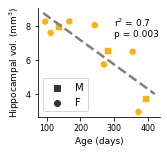

In [7]:
plt.figure(1, figsize = [2.2,2])

shapes = {'M': 's', 'F': 'o'}

scatter = sns.scatterplot(data = Histology_df, x = 'Ages', y='Volumes', s = 50, color = sns.xkcd_rgb['saffron'], 
                style='Sexes', markers=shapes)

# set the title of the legend to an empty string
legend = scatter.legend()
legend.set_title('')
# move the legend to the bottom left corner
legend.set_bbox_to_anchor((0.45, 0.4))

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(Ages, Volumes)
fitxs = np.arange(90,420,1)
fitys = slope*fitxs + intercept
plt.plot(fitxs, fitys, color = 'grey', linestyle = '--', linewidth=2.5)
plt.text(300, 8, 'r$^2$ = ' + str(round(r_value**2,3)), fontsize=9)
plt.text(300, 7.4, 'p = ' + str(round(p_value,3)), fontsize=9)

plt.xticks(fontsize = 8)
plt.yticks(fontsize = 8)
plt.xlabel('Age (days)', fontsize = 9)
plt.ylabel('Hippocampal vol. (mm$^3$)', fontsize = 9)

sns.despine()


if SAVEFIGS:
    plt.savefig(f'/{basedir}/HlabShare/te4_manuscript_james/manuscript_folders/UPDATED_Fig1_figures/{today}_HippVolume_vs_Age.pdf', bbox_inches = "tight")
    

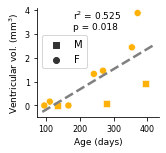

In [8]:
plt.figure(1, figsize = [2.2,2])

shapes = {'M': 's', 'F': 'o'}

scatter = sns.scatterplot(data = Histology_df, x = 'Ages', y='Ventricles', s = 50, color = sns.xkcd_rgb['saffron'], 
                style='Sexes', markers=shapes)

# set the title of the legend to an empty string
legend = scatter.legend()
legend.set_title('')
# move the legend to the bottom left corner
legend.set_bbox_to_anchor((0.45, 0.4))

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(Ages, Ventricles)
fitxs = np.arange(90,420,1)
fitys = slope*fitxs + intercept
plt.plot(fitxs, fitys, color = 'grey', linestyle = '--', linewidth=2.5)
plt.text(180,3.6, 'r$^2$ = ' + str(round(r_value**2,3)), fontsize=9)
plt.text(180, 3.2, 'p = ' + str(round(p_value,3)), fontsize=9)
#plt.ylim([0,4.2])
plt.xticks(fontsize = 8)
plt.yticks(fontsize = 8)
plt.xlabel('Age (days)', fontsize = 9)
plt.ylabel('Ventricular vol. (mm$^3$)', fontsize = 9)

sns.despine()

if SAVEFIGS:
    plt.savefig(f'/{basedir}/HlabShare/te4_manuscript_james/manuscript_folders/UPDATED_Fig1_figures/{today}_VentricularVolume_vs_Age.pdf', bbox_inches = "tight")
    

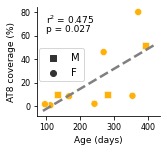

In [9]:
plt.figure(1, figsize = [2.2,2])

shapes = {'M': 's', 'F': 'o'}

scatter = sns.scatterplot(data = Histology_df, x = 'Ages', y='ATs', s = 50, color = sns.xkcd_rgb['saffron'], 
                style='Sexes', markers=shapes)

# set the title of the legend to an empty string
legend = scatter.legend()
legend.set_title('')
# move the legend to the bottom left corner
legend.set_bbox_to_anchor((0.42, 0.27))

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(Ages, ATs_james)
fitxs = np.arange(90,420,1)
fitys = slope*fitxs + intercept
plt.plot(fitxs, fitys, color = 'grey', linestyle = '--', linewidth=2.5)
plt.text(100, 70, 'r$^2$ = ' + str(round(r_value**2,3)), fontsize=9)
plt.text(100, 63, 'p = ' + str(round(p_value,3)), fontsize=9)
plt.xticks(fontsize = 8)
plt.yticks(fontsize = 8)
plt.xlabel('Age (days)', fontsize = 9)
plt.ylabel('AT8 coverage (%)', fontsize = 9)

sns.despine()

if SAVEFIGS:
    plt.savefig(f'/{basedir}/HlabShare/te4_manuscript_james/manuscript_folders/UPDATED_Fig1_figures/{today}_AT8_vs_Age.pdf', bbox_inches = "tight")
    